# **Algorithmic Methods of Data Mining - Fall 2022**

## **Homework 5: The Marvel Universe!**

**Packages that are used troughout the notebook:**

In [1]:
# For data analysis and manipulation
import pandas as pd
import numpy as np

# For graph representation and algos
import networkx as nx

# Utils
from tqdm import tqdm
from itertools import combinations
import sys
from tabulate import tabulate

# Sanity
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# For plotting
import plotly.express as px
import plotly.graph_objects as go

# Our scripts
import scripts

## 1. Data

### Matching hero names
Here we examine and prepare the data so that the hero names match between the two datasets. 

In [2]:
# Load data and strip forward slashes and whitespace
nodes = pd.read_csv('data/nodes.csv').applymap(lambda x: x.rstrip('/').strip())
edges = pd.read_csv('data/edges.csv').applymap(lambda x: x.rstrip('/').strip())
network = pd.read_csv('data/hero-network.csv').applymap(lambda x: x.rstrip('/').strip())

In [3]:
# Unique heroes in each dataframe
node_heroes = set(nodes[nodes['type'] == 'hero']['node'])
edge_heroes = set(edges['hero'])
network_heroes = set(pd.concat([network['hero1'], network['hero2']]))

# Number of unique heroes in each dataframe
len(node_heroes), len(edge_heroes), len(network_heroes)

(6439, 6439, 6421)

We would like to have each hero in edges and network represented in the nodes dataframe. So let's see which ones do not have a match in the nodes dataframe.

In [4]:
print('Heroes in edges but not in nodes:', edge_heroes - node_heroes)
print('Heroes in nodes but not in edges:', node_heroes - edge_heroes)

Heroes in edges but not in nodes: {'SPIDER-MAN/PETER PARKER'}
Heroes in nodes but not in edges: {'SPIDER-MAN/PETER PARKERKER'}


In [5]:
# Fix spiderman's name in nodes
nodes.loc[nodes['node'] == 'SPIDER-MAN/PETER PARKERKER', 'node'] = 'SPIDER-MAN/PETER PARKER'

# Update the heroe set for nodes
node_heroes = set(nodes[nodes['type'] == 'hero']['node'])

# Now let's check the network dataframe
print('Heroes in network but not in nodes:', network_heroes - node_heroes)

Heroes in network but not in nodes: {'SPIDER-MAN/PETER PAR'}


In [6]:
# Fix spiderman's name in network
network = network.applymap(lambda x: 'SPIDER-MAN/PETER PARKER' if x == 'SPIDER-MAN/PETER PAR' else x)
network_heroes = set(pd.concat([network['hero1'], network['hero2']]))

# Now we have every hero in the nodes dataframe
print('Number of heroes in nodes but not in network:', len(node_heroes - network_heroes))

Number of heroes in nodes but not in network: 18


We have processed the data such that all the heroes exist in the nodes df. Now let's drop the rows in the network df which have the same hero pair.

In [7]:
# drop same hero pairs
network = network[network['hero1'] != network['hero2']].reset_index(drop=True)

# Are the comics in the nodes and edges matching?
nodes_comics = set(nodes[nodes['type'] == 'comic']['node'])
edges_comics = set(edges['comic'])
len(nodes_comics), len(edges_comics), len(nodes_comics ^ edges_comics) # The comics are matching

(12651, 12651, 0)

Also, we have discovered that there are some heroes and comics that share the same name. We will add "_c" to the comic name so that it will have its own unique node for the upcoming analysis.

In [8]:
iffy_comics = nodes.loc[nodes['node'].duplicated(keep=False) & (nodes['type'] == 'comic'), 'node']
nodes.loc[nodes['node'].isin(iffy_comics) & (nodes['type'] == 'comic'), 'node'] += '_c'
edges.loc[edges['comic'].isin(iffy_comics), 'comic'] += '_c'
iffy_comics

2078     BLADE
13362    REBEL
13704    SABRE
Name: node, dtype: object

Weirdly enough, the network dataset does not correspond to the nodes and edges dataset. Meanwhile, the nodes and edges dataset does correspond to each other perfectly. Ideally, the network dataset should represent the collaboration of heroes in each comic. So, moving on we will use our own network dataset. Below, you can see that they have similar number of rows, which suggest that the network dataset should have been corresponding to the nodes and edges dataset.

In [9]:
# Here we create are own network dataframe
my_network = []

for comic, heroes in tqdm(edges.groupby('comic')['hero']):
    heroes = sorted(heroes)
    for combo in combinations(heroes, 2):

        my_network.append({'hero1': combo[0], 'hero2': combo[1], 'comic': comic})

my_network = pd.DataFrame(my_network)
my_network.shape, network.shape

100%|██████████| 12651/12651 [00:01<00:00, 10913.66it/s]


((579171, 3), (572235, 2))

In [10]:
# Delete unnecessary variables
del combo, comic, edge_heroes, edges_comics, heroes, iffy_comics, network_heroes, node_heroes, nodes_comics

## 2. Backend Implementation
We start by creating a list of heroes and their number of appearances so that we can get the top N heroes when needed.

In [11]:
heroes = edges.groupby('hero').size().sort_values(ascending=False)
heroes.head(5)

hero
SPIDER-MAN/PETER PARKER    1577
CAPTAIN AMERICA            1334
IRON MAN/TONY STARK        1150
THING/BENJAMIN J. GR        963
THOR/DR. DONALD BLAK        956
dtype: int64

#### Creating the **First Graph**

We have a bit of an interesting idea to readjust the weights of the edges. You have asked us to have a lower weight/cost for heroes that appear together more frequently. We will add a **small twist** to this idea. These weights will be adjusted based on the number of appearances of the heroes. We will use the following formula to calculate the weight of an edge:
$$
w_{ij} = \frac{|c \in C: h_i \in c| + |c \in C: h_j \in c|}{|c \in C: h_i, h_j \in c|}
$$
where $C$ is the set of all comics, $h_i$ and $h_j$ are two arbitrary heroes in the Marvel Universe. In other words, weight $w_{ij}$ is the inverse of the probability that the two heroes appear together.

In [12]:
edges_weighted = my_network.groupby(['hero1', 'hero2']).size().reset_index().sort_values(by=0, ascending=False)
edges_weighted.columns = ['hero1', 'hero2', 'colab']

edges_weighted['tot'] = edges_weighted['hero1'].map(heroes) + edges_weighted['hero2'].map(heroes)
edges_weighted['weight'] = edges_weighted['tot'] / edges_weighted['colab'] / 2
edges_weighted.sort_values(by='weight', ascending=False)

,hero1,hero2,colab,tot,weight
102965,"HOGAN, VIRGINIA PEPP",SPIDER-MAN/PETER PARKER,1,1696,848.0
165143,SPIDER-MAN/PETER PARKER,"TARR, BLACK JACK",1,1679,839.5
145161,NOMAD III/JACK MONRO,SPIDER-MAN/PETER PARKER,1,1662,831.0
164378,"SMITH, SIR DENIS NAY",SPIDER-MAN/PETER PARKER,1,1661,830.5
165085,SPIDER-MAN/PETER PARKER,STARSHINE II/BRANDY,1,1649,824.5
...,...,...,...,...,...
137716,MINOTAUR III,SPHINX III,1,2,1.0
92608,GOROTH,STAR HAMMER,1,2,1.0
103519,"HONIKAWA, SHO","NICHOLS, TOM",2,4,1.0
92612,GOROTH,WEBWING,1,2,1.0


Above you can see the most extreme cases of the weights. The worst case is having to appear once with a very popular hero. And the best cases are when heroes appear always together. Now, we use this dataframe to create Graph 1.

In [13]:
G1 = nx.from_pandas_edgelist(edges_weighted, 'hero1', 'hero2', 'weight')
G1.name = 'First Graph'
G1.number_of_nodes(), G1.number_of_edges()

(6421, 171644)

#### Creating the **Second Graph**
Here, we simply create **Graph 2** by using nodes and edges dataframes.

In [14]:
G2 = nx.from_pandas_edgelist(edges, 'hero', 'comic')
G2.name = 'Second Graph'
G2.number_of_nodes(), G2.number_of_edges(), nodes.shape[0], edges.shape[0]
G2.add_nodes_from(nodes[nodes['type'] == 'hero']['node'], type='hero')
G2.add_nodes_from(nodes[nodes['type'] == 'comic']['node'], type='comic')
G2.number_of_nodes(), G2.number_of_edges()

(19090, 96104)

In [15]:
# Delete unnecessary variables
del edges_weighted

### Functionalities
This part is dedicated to the functionalities of the program. We have implemented as instructed. Here we run the **verbose** mode to show the results of the functionalities.

In [16]:
# impoting our functions 
funcs = scripts.Funcs(heroes)

#### Functionality 1 - extract the graph's features

In [17]:
_ = funcs.graph_summary(G1, 100)
print()
_ = funcs.graph_summary(G2, 100)

Extracting features for the First Graph...
Number of nodes: 100
Network density: 0.8255
Average degree: 81.7200
10 example hub nodes: CYCLOPS/SCOTT SUMMER	WOLVERINE/LOGAN	HUMAN TORCH/JOHNNY S	MR. FANTASTIC/REED R	CAPTAIN AMERICA
The network is sparse: False

Extracting features for the Second Graph...
Number of nodes: 10570
Network density: 0.0007
Average degree: 7.2112
10 example hub nodes: COC 1	H2 279	ANGEL/WARREN KENNETH	IW 2	IW 3	IW 4	M/GN 1	MK3 41	ANT-MAN/DR. HENRY J.	BALDER [ASGARDIAN]
The network is sparse: True


### Functionality 2 - Find top superheroes!

In [18]:
_ = funcs.top_heroes(G1, node='CAPTAIN AMERICA', metric=1, N=30)
_ = funcs.top_heroes(G1, node='CAPTAIN AMERICA', metric=2, N=30)
_ = funcs.top_heroes(G1, node='CAPTAIN AMERICA', metric=3, N=30)
_ = funcs.top_heroes(G1, node='CAPTAIN AMERICA', metric=4, N=30)

CAPTAIN AMERICA's Betweeness: 0.2340
CAPTAIN AMERICA's PageRank: 0.0224
CAPTAIN AMERICA's ClosenessCentrality: 0.5845
CAPTAIN AMERICA's DegreeCentrality: 0.2989


### Functionality 3 - Shortest ordered Route

In [19]:
_ = funcs.shortest_route(G2, heroes[:5].index, 10)

Graph named 'Second Graph' with 19090 nodes and 96104 edges
Shortest route: ['SPIDER-MAN/PETER PARKER', 'A 11', 'CAPTAIN AMERICA'] ['CAPTAIN AMERICA', "A '00", 'IRON MAN/TONY STARK'] ['IRON MAN/TONY STARK', 'A 1', 'THING/BENJAMIN J. GR'] ['THING/BENJAMIN J. GR', 'A 1', 'THOR/DR. DONALD BLAK'] ['THOR/DR. DONALD BLAK', 'A 1', 'HUMAN TORCH/JOHNNY S'] ['HUMAN TORCH/JOHNNY S', 'A 1', 'MR. FANTASTIC/REED R'] ['MR. FANTASTIC/REED R', 'A 1', 'HULK/DR. ROBERT BRUC'] ['HULK/DR. ROBERT BRUC', 'A3 10', 'WOLVERINE/LOGAN'] ['WOLVERINE/LOGAN', 'A3 10', 'INVISIBLE WOMAN/SUE']


### Functionality 4 - Disconnecting Graphs

In [20]:
_ = funcs.disconnecting_graphs(G1, heroes.index[30], heroes.index[40], 100, True)

Number of links to cut to disconnect SHE-HULK/JENNIFER WA and ODIN [ASGARDIAN]: 68
Path exists between SHE-HULK/JENNIFER WA and ODIN [ASGARDIAN]: False


### Functionality 5 - Extracting Communities

In [21]:
_ = funcs.extracting_communities(G1, 10, 'CAPTAIN AMERICA', 'IRON MAN/TONY STARK')

Communities:
Community 1: HUMAN TORCH/JOHNNY S
Community 2: THING/BENJAMIN J. GR MR. FANTASTIC/REED R THOR/DR. DONALD BLAK CAPTAIN AMERICA WOLVERINE/LOGAN INVISIBLE WOMAN/SUE SPIDER-MAN/PETER PARKER IRON MAN/TONY STARK HULK/DR. ROBERT BRUC
Path exists between CAPTAIN AMERICA and IRON MAN/TONY STARK: True
Number of edges to cut to form communities: 9


## 3. Frontend Implementation
Here we put the functionalities at use and use them create infographics regarding the Marvel Universe. Let's start by importing `Visualz` class that you can find in `scripts.py` file.

In [22]:
viz = scripts.Visualz(heroes)

### Visualization 1 - Visualize some features of the network

In [23]:
viz.viz1(G1, 3000)

+-------+-------------------+----------------------------+-------------------+------------------+------------+
|       |   Number of nodes |   Number of collaborations |   Network density |   Average degree | Sparsity   |
|-------+-------------------+----------------------------+-------------------+------------------+------------|
| Value |              3000 |                     124977 |         0.0277819 |           83.318 | True       |
+-------+-------------------+----------------------------+-------------------+------------------+------------+
Hub nodes: FURY, COL. NICHOLAS	HUMAN TORCH/JOHNNY S	CAPTAIN AMERICA	STORM/ORORO MUNROE S	ANT-MAN/DR. HENRY J.	COLOSSUS II/PETER RA	HULK/DR. ROBERT BRUC	THING/BENJAMIN J. GR	IRON MAN/TONY STARK	BEAST/HENRY &HANK& P


### Visualization 2 - Visualize centrality measure

In [24]:
viz.viz2(G1, 50, heroes.index[1], 1)

╒════════════════╤══════════════════════╕
│                │ Value                │
╞════════════════╪══════════════════════╡
│ Average metric │ 0.029676870748299312 │
├────────────────┼──────────────────────┤
│ Metric of node │ 0.179421768707483    │
├────────────────┼──────────────────────┤
│ Name of metric │ Betweeness           │
╘════════════════╧══════════════════════╛


### Visualization 3 - Visualize the shortest-ordered route

In [40]:
viz.viz3(G2, heroes.index[:5], 15)

Shortest route: ['SPIDER-MAN/PETER PARKER', 'A 11', 'CAPTAIN AMERICA'] ['CAPTAIN AMERICA', "A '00", 'IRON MAN/TONY STARK'] ['IRON MAN/TONY STARK', 'A 1', 'THING/BENJAMIN J. GR'] ['THING/BENJAMIN J. GR', 'A 1', 'THOR/DR. DONALD BLAK'] ['THOR/DR. DONALD BLAK', 'A 1', 'HUMAN TORCH/JOHNNY S'] ['HUMAN TORCH/JOHNNY S', 'A 1', 'MR. FANTASTIC/REED R'] ['MR. FANTASTIC/REED R', 'A 1', 'HULK/DR. ROBERT BRUC'] ['HULK/DR. ROBERT BRUC', 'A3 10', 'WOLVERINE/LOGAN'] ['WOLVERINE/LOGAN', 'A3 10', 'INVISIBLE WOMAN/SUE'] ['INVISIBLE WOMAN/SUE', 'A 1', 'SCARLET WITCH/WANDA'] ['SCARLET WITCH/WANDA', 'A 10', 'BEAST/HENRY &HANK& P'] ['BEAST/HENRY &HANK& P', 'A 157', 'DR. STRANGE/STEPHEN'] ['DR. STRANGE/STEPHEN', 'A 168', 'WATSON-PARKER, MARY'] ['WATSON-PARKER, MARY', 'ASM2 1', 'DAREDEVIL/MATT MURDO']
+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+
|            | Comic 1  

### Visualization 4 - Visualize the disconnected graph
Due to the nature of the graph, the solutions we get here alwaus single out a particular node to create two separate graphs.

In [26]:
viz.viz4(G1, 40, heroes.index[20], heroes.index[21])

Number of links to cut to disconnect ANT-MAN/DR. HENRY J. and SUB-MARINER/NAMOR MA: 39


### Visualization 5 - Visualize the communities
Again like the previous part, we are having some problems with the nature of the graph. Since top heroes are closely connected to each other, we are not able to find communities. Again, the algorithms singles out a particular node to create two separate graphs.

In [42]:
viz.viz5(G1, 30, 'CAPTAIN AMERICA', 'IRON MAN/TONY STARK')

## 4. Command Line Questions

In [28]:
%%bash

#1.What is the most popular pair of heroes (often appearing together in the comics)?
echo "Most popular pair of heroes:"
awk 'NR>1{c[$0]++} END{for (k in c)print k,","c[k]}' data/hero-network.csv | sort -k3 -nr -t,  > cl_output/uniq-sort.txt
head -n 1 cl_output/uniq-sort.txt 

#2.Number of comics per hero.
echo "Number of comics per hero:"
cut -d',' -f1 data/edges.csv | awk 'NR>1{c[$0]++} END{for (k in c)print k,","c[k]}' > cl_output/num_com_per_hero.txt
head -n 10 cl_output/num_com_per_hero.txt

#3.Average number of heroes per comic
echo "Average number of heroes per comic:"
sort -u data/edges.csv | cut -d',' -f1 data/edges.csv | awk 'NR>1{c[$0]++} END{for (k in c)print k,","c[k]}' | awk -F',' '{sum+=$2; ++n} END { print "Avg: "sum"/"n"="sum/n }' 

Most popular pair of heroes:
"PATRIOT/JEFF MACE","PATRIOT/JEFF MACE" ,1275
Number of comics per hero:
SODIUM ,2
"MUNROE ,3
ACROBAT/CARL ZANTE ,3
"BAPTISTE ,1
MAN-BULL/BULL TAURUS ,9
SIBERCAT/ ,2
BRUTE/REED RICHARDS ,9
RINGMASTER/MAYNARD T ,34
"MARLOPOLIS ,1
MASTER MAN II/ALEXAN ,2
Average number of heroes per comic:
Avg: 96104/5777=16.6356


## 5. Bonus - PageRank on MapReduce

For the implementation of `PageRank` using `PySpark` and MapReduce, we will use the following dataset:

In [29]:
# We will use the mapreduce function to compute the pagerank
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setAppName('appName').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

import scipy.sparse as sp

23/01/08 21:53:38 WARN Utils: Your hostname, macbook-3.local resolves to a loopback address: 127.0.0.1; using 192.168.1.74 instead (on interface en0)
23/01/08 21:53:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/08 21:53:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [30]:
# We will create an adjacency matrix using scipy.sparse
M = nx.adjacency_matrix(G1)
# Divide each row by the number of outgoing edges
M = sp.csr_matrix(M / M.sum(axis=0))
# Initialize the pagerank vector
q = np.ones(M.shape[0]) / M.shape[0]
# Let's look at the shapes, and sum of rows all should be 1
M.shape, q.shape, sum(q)

((6421, 6421), (6421,), 0.999999999999877)

In [31]:
# We will break M into k vertical strips and create a list of k matrices
k = 20
n = M.shape[1]
M_list = [M[:, i*M.shape[0]//k : (i+1)*M.shape[0]//k] for i in range(k)]

# We will also break q into k horizontal strips and create a list of k vectors
q_list = [q[i*M.shape[0]//k : (i+1)*M.shape[0]//k] for i in range(k)]

# Check if things are correct
print(f'Total number of columns in M and sum of the columns in M_list: {M.shape[1]}, {sum([x.shape[1] for x in M_list])}')
print(f'Total number of rows in q and sum of the rows in q_list: {q.shape[0]}, {sum([x.shape[0] for x in q_list])}')
[x.shape for x in M_list[:5]], [x.shape for x in q_list[:5]]

Total number of columns in M and sum of the columns in M_list: 6421, 6421
Total number of rows in q and sum of the rows in q_list: 6421, 6421


([(6421, 321), (6421, 321), (6421, 321), (6421, 321), (6421, 321)],
 [(321,), (321,), (321,), (321,), (321,)])

In [32]:
# The map function will multiply strip of M with strip of q, and emit each row of the result
def map_pr(j, M, q):
    return M.dot(q)

# The reduce function will adds values for each key i to get the pagerank for node i
beta = 0.85
def reduce_pr(x, y):
    return (x + y)

# Let's bring everything together in a function
def pagerank(M, q, k, beta=0.85, n_iter=50):
    # resillient distributed dataset
    rdd = sc.parallelize(range(k), k)

    # We will break M into k vertical strips and create a list of k matrices
    M_list = [M[:, i*M.shape[0]//k : (i+1)*M.shape[0]//k] for i in range(k)]
    
    # We will use the mapreduce function to compute the pagerank
    for i in tqdm(range(n_iter)):
        # We will also break q into k horizontal strips and create a list of k vectors
        q_list = [q[i*M.shape[0]//k : (i+1)*M.shape[0]//k] for i in range(k)]
        q = rdd.map(lambda j: map_pr(j, M_list[j], q_list[j])).reduce(reduce_pr) * beta + (1 - beta) / n
    return q

In [33]:
q_star = pagerank(M, q, k=20, beta=0.85, n_iter=30)

100%|██████████| 30/30 [00:20<00:00,  1.50it/s]                                 


In [34]:
# Plotly bar chart of top 20 pagerank values

hero_pr = pd.DataFrame({'hero': list(G1.nodes()), 'pagerank': q_star})
hero_pr = hero_pr.sort_values('pagerank', ascending=False).head(20)
hero_pr.sort_values('pagerank', ascending=True, inplace=True)

fig = px.bar(hero_pr, x='pagerank', y='hero', orientation='h', title='Top 20 Pagerank Values', color='pagerank', color_continuous_scale=px.colors.sequential.Plasma)
fig.update_layout(height=800, width=800)
fig.show()

## 6. Algorithmic Question

Alex and Sarah have been together for two years, and Alex is now thinking
about proposing to her. But, to surprise her, he wants to install an app on her
phone that asks her if she will marry him at the right time.


However, to install the application secretly, he needs her phone's password,
which he does not have. He knows her password is a poly-line made up of
vertical or horizontal line segments. In a 3*3 grid, each line segment
connects the centres of two cells. Alex learned the direction of each line
segment by looking at her hand while unlocking her phone. He didn't pay
much attention to the length of each line segment, but he is sure that her
phone's operating system does not allow the poly-line to intersect with itself
even at one point.


Alex wants to distract Sarah's attention long enough to test all possible
patterns based on the directions of the line segments he has learned.
Therefore, he needs you to assist him in calculating how many possible
patterns he has to try based on those directions to estimate how much time he
needs to check all of those possibilities. Given that the line segments were
directed right, down, left, and up, the following figure depicts two valid and
one invalid (as the poly-lines should not intersect even in one point) patterns.

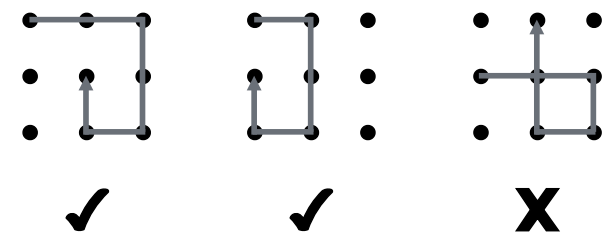

In [35]:
from IPython import display
display.Image("data/Examples.png")

**Input**:

The input is a single string that shows the direction of the segment lines and
contains only the characters R, L, U, and D, which correspond to the Right,
Left, Up, and Down directions. The string's maximum length is 10. It is also
guaranteed that two consecutive characters will be different.

**Output**:

We expect to see only 1 number in the output, corresponding to the number
of different patterns that can be generated based on the line segments Alex
learned. In some cases, this number may be 0, indicating that no patterns can
be generated using the learned line segments.

**Examples**:

DRU --> 15

R --> 9

LDRDRUL --> 0

We are going to consider that all the moves can have length 1 or 2, since the length of the directions is unkown.

We will also use the varibale `pos`, to indicate where the last instruction finished.

In [36]:
def password_count(instr):     # NOTE: The comments for the 1st if and the first if inside the while are
                               # the same for the other cases, just changing right for the corresponding direction.
    counter=0 # Counter for number of possible paths
    n=len(instr)
    
    if instr[0]=='D': # If the first instruction is DOWN, we cannot start from the last row
        instr.pop(0)    # We drop the first letter
        instr2=instr.copy()
        for i in range(0,2):     # These loops move us through the different starting positions that we can have
            for j in range(0,3):
                paths=[]
                for k in range(i+1,3):
                    paths.append([[i,j],[k,j]]) # And we initialize paths where each will start from a 
                while(len(instr2)>0):           # starting point among the available ones
                    com=instr2[0]               # While there are still directions to follow, we drop that
                    instr2.pop(0)
                    if com=='R':
                        for k in paths:   # For every path, we take the last visited position and we also store a 
                            last=k[-1]    # copy for the path
                            aux=k.copy()
                            if last[1]+1<3 and [last[0],last[1]+1] not in k: #If the position moved to the right
                                k.append([last[0],last[1]+1])    # 1 step is valid and has not been visited
                                                                # We add it to the path. Same for 2 steps,
                                                                # And if the conditions are satisfied we add the 
                            if last[1]+2<3 and [last[0],last[1]+2] not in k:   #whole new path
                                aux.append([last[0],last[1]+2])
                                paths.append(aux)
                    elif com=='U':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[0]-1>=0 and [last[0]-1,last[1]] not in k:
                                k.append([last[0]-1,last[1]])
                            if last[0]-2>=0 and [last[0]-2,last[1]] not in k:
                                aux.append([last[0]-2,last[1]])
                                paths.append(aux)
                    elif com=='L':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[1]-1>=0 and [last[0],last[1]-1] not in k:
                                k.append([last[0],last[1]-1])
                            if last[1]-2>=0 and [last[0],last[1]-2] not in k:
                                aux.append([last[0],last[1]-2])
                                paths.append(aux)
                    elif com=='D':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[0]+1<3 and [last[0]+1,last[1]] not in k:
                                k.append([last[0]+1,last[1]])
                            if last[0]+2<3 and [last[0]+2,last[1]] not in k:
                                aux.append([last[0]+2,last[1]])
                                paths.append(aux)
                                
                instr2=instr.copy() #after the while, we put the initial directions, not the very first one, 
                                    #so we can proceed in the same way with the other initial positions 
                for k in paths:
                    if len(k)==n+1:  #If the path has the lenght =length(instr)+1, which means that it has changed the
                                    # direction n times, then we add one to the counter
                        counter+=1

    elif instr[0]=='U': # If the first instruction is UP, we cannot start from the first row
        instr.pop(0)
        instr2=instr.copy()
        for i in range(1,3):
            for j in range(0,3):
                paths=[]
                for k in range(i-1,-1,-1):
                    paths.append([[i,j],[k,j]])
                while(len(instr2)>0):
                    com=instr2[0]
                    instr2.pop(0)
                    if com=='R':
                        print('R')
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[1]+1<3 and [last[0],last[1]+1] not in k:
                                k.append([last[0],last[1]+1])
                            if last[1]+2<3 and [last[0],last[1]+2] not in k:
                                aux.append([last[0],last[1]+2])
                                paths.append(aux)
                    elif com=='U':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[0]-1>=0 and [last[0]-1,last[1]] not in k:
                                k.append([last[0]-1,last[1]])
                            if last[0]-2>=0 and [last[0]-2,last[1]] not in k:
                                aux.append([last[0]-2,last[1]])
                                paths.append(aux)
                    elif com=='L':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[1]-1>=0 and [last[0],last[1]-1] not in k:
                                k.append([last[0],last[1]-1])
                            if last[1]-2>=0 and [last[0],last[1]-2] not in k:
                                aux.append([last[0],last[1]-2])
                                paths.append(aux)
                    elif com=='D':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[0]+1<3 and [last[0]+1,last[1]] not in k:
                                k.append([last[0]+1,last[1]])
                            if last[0]+2<3 and [last[0]+2,last[1]] not in k:
                                aux.append([last[0]+2,last[1]])
                                paths.append(aux)
                instr2=instr.copy()
                for k in paths:
                    if len(k)==n+1:
                        counter+=1
                
    elif instr[0]=='R': # If the first instruction is RIGHT, we cannot start from the last column
        instr.pop(0)
        instr2=instr.copy()
        for i in range(0,3):
            for j in range(0,2):
                paths=[]
                for k in range(j+1,3):
                    paths.append([[i,j],[i,k]])
                while(len(instr2)>0):
                    com=instr2[0]
                    instr2.pop(0)
                    if com=='R':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[1]+1<3 and [last[0],last[1]+1] not in k:
                                k.append([last[0],last[1]+1])
                            if last[1]+2<3 and [last[0],last[1]+2] not in k:
                                aux.append([last[0],last[1]+2])
                                paths.append(aux)
                    elif com=='U':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[0]-1>=0 and [last[0]-1,last[1]] not in k:
                                k.append([last[0]-1,last[1]])
                            if last[0]-2>=0 and [last[0]-2,last[1]] not in k:
                                aux.append([last[0]-2,last[1]])
                                paths.append(aux)
                    elif com=='L':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[1]-1>=0 and [last[0],last[1]-1] not in k:
                                k.append([last[0],last[1]-1])
                            if last[1]-2>=0 and [last[0],last[1]-2] not in k:
                                aux.append([last[0],last[1]-2])
                                paths.append(aux)
                    elif com=='D':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[0]+1<3 and [last[0]+1,last[1]] not in k:
                                k.append([last[0]+1,last[1]])
                            if last[0]+2<3 and [last[0]+2,last[1]] not in k:
                                aux.append([last[0]+2,last[1]])
                                paths.append(aux)
                instr2=instr.copy()
                for k in paths:
                    if len(k)==n+1:
                        counter+=1
                
    elif instr[0]=='L': # If the first instruction is LEFT, we cannot start from the first column
        instr.pop(0)
        instr2=instr.copy()
        for i in range(0,2):
            for j in range(1,3):
                paths=[]
                for k in range(j-1,-1,-1):
                    paths.append([[i,j],[i,k]])
                while(len(instr2)>0):
                    com=instr2[0]
                    instr2.pop(0)
                    if com=='R':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[1]+1<3 and [last[0],last[1]+1] not in k:
                                k.append([last[0],last[1]+1])
                            if last[1]+2<3 and [last[0],last[1]+2] not in k:
                                aux.append([last[0],last[1]+2])
                                paths.append(aux)
                    elif com=='U':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[0]-1>=0 and [last[0]-1,last[1]] not in k:
                                k.append([last[0]-1,last[1]])
                            if last[0]-2>=0 and [last[0]-2,last[1]] not in k:
                                aux.append([last[0]-2,last[1]])
                                paths.append(aux)
                    elif com=='L':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[1]-1>=0 and [last[0],last[1]-1] not in k:
                                k.append([last[0],last[1]-1])
                            if last[1]-2>=0 and [last[0],last[1]-2] not in k:
                                aux.append([last[0],last[1]-2])
                                paths.append(aux)
                    elif com=='D':
                        for k in paths:
                            last=k[-1]
                            aux=k.copy()
                            if last[0]+1<3 and [last[0]+1,last[1]] not in k:
                                k.append([last[0]+1,last[1]])
                            if last[0]+2<3 and [last[0]+2,last[1]] not in k:
                                aux.append([last[0]+2,last[1]])
                                paths.append(aux)
                instr2=instr.copy()
                for k in paths:
                    if len(k)==n+1:
                        counter+=1
                
        
    return(counter)

In [37]:
txt='DRU'
instructions=[*txt]
password_count(instructions)

15

In [38]:
txt2='R'
instructions2=[*txt2]
password_count(instructions2)

9

In [39]:
txt3='LDRDRUL'
instructions3=[*txt3]
password_count(instructions3)

0